# LLAMA3 Fine-tuning for text classification using QLORA

This notebook is an adaption of the notebook provided in the following work:
https://arxiv.org/abs/2305.14314

This notebook is derived from:
https://github.com/adidror005/youtube-videos/blob/main/LLAMA_3_Fine_Tuning_for_Sequence_Classification_Actual_Video.ipynb

### Requirements:
* Nvidia/Tesla T4 GPU with 15GB would work if you just do a train-test split on a relative small dataset. For cross-validation you need access to Colab Pro and select A100 GPU.

### Installs
* They suggest using latest version of transformers
* Must restart after install because the accelerate package used in the hugging face trainer requires it.

Add the following secrets to Colab's secret:
* huggingface - hugging face token to access models

In [ ]:
# Install Pytorch
%pip install "torch==2.2.2" tensorboard

# Install Hugging Face libraries
%pip install  --upgrade "transformers==4.40.0" "datasets==2.18.0" "accelerate==0.29.3" "evaluate==0.4.1" "bitsandbytes==0.43.1" "huggingface_hub==0.22.2" "trl==0.8.6" "peft==0.10.0"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Big Picture Overview of Parameter Efficient Fine Tuning Methods like LoRA and QLoRA Fine Tuning for Sequence Classification

**The Essence of Fine-tuning**
- LLMs are pre-trained on vast amounts of data for broad language understanding.
- Fine-tuning is crucial for specializing in specific domains or tasks, involving adjustments with smaller, relevant datasets.

**Model Fine-tuning with PEFT: Exploring LoRA and QLoRA**
- Traditional fine-tuning is resource-intensive; PEFT (Parameter Efficient Fine-tuning) makes the process faster and less demanding.
- Focus on two PEFT methods: LoRA and QLoRA.

**The Power of PEFT**
- PEFT modifies only a subset of the LLM's parameters, enhancing speed and reducing memory demands, making it suitable for less powerful devices.

**LoRA: Efficiency through Adapters**
- **Low-Rank Adaptation (LoRA):** Injects small trainable adapters into the pre-trained model.
- **Equation:** For a weight matrix $W$, LoRA approximates $W = W_0 + BA$, where $W_0$ is the original weight matrix, and $BA$ represents the low-rank modification through trainable matrices $B$ and $A$.
- Adapters learn task nuances while keeping the majority of the LLM unchanged, minimizing overhead.

**QLoRA: Compression and Speed**
- **Quantized LoRA (QLoRA):** Extends LoRA by quantizing the model’s weights, further reducing size and enhancing speed.
- **Innovations in QLoRA:**
  1. **4-bit Quantization:** Uses a 4-bit data type, NormalFloat (NF4), for optimal weight quantization, drastically reducing memory usage.
  2. **Low-Rank Adapters:** Fine-tuned with 16-bit precision to effectively capture task-specific nuances.
  3. **Double Quantization:** Reduces quantization constants from 32-bit to 8-bit, saving additional memory without accuracy loss.
  4. **Paged Optimizers:** Manages memory efficiently during training, optimizing for large tasks.

**Why PEFT Matters**
- **Rapid Learning:** Speeds up model adaptation.
- **Smaller Footprint:** Eases deployment with reduced model size.
- **Edge-Friendly:** Fits better on devices with limited resources, enhancing accessibility.

**Conclusion**
- PEFT methods like LoRA and QLoRA revolutionize LLM fine-tuning by focusing on efficiency, facilitating faster adaptability, smaller models, and broader device compatibility.




### Fine-tuning for Text Classification:

Two fine-tuning procedures are possible:

#### 1. Text Generation with Classification Label as part of text
- **Approach**: Train the model to generate text that naturally appends the classification label at the end.
- **Input**: "Lorem ipsum dolor sit amet, consectetur adipiscing elit"
- **Output**: "Lorem ipsum dolor sit amet, consectetur adipiscing elit 0.25"
- **Use Case**: This method is useful for classifiying text


#### 2. Sequence Classification Head
- **Approach**: Add a sequence classification head (linear layer) on top of the LLaMa Model transformer. This setup is similar to GPT-2 and focuses on classifying the sentiment based on the last relevant token in the sequence.
    - **Token Positioning**:
        - **With pad_token_id**: The model identifies and ignores padding tokens, using the last non-padding token for classification.
        - **Without pad_token_id**: It defaults to the last token in each sequence.
        - **inputs_embeds**: If embeddings are directly passed (without input_ids), the model cannot identify padding tokens and takes the last embedding in each sequence as the input for classification.
- **Input**: Specific sentences (e.g., "Lorem ipsum dolor sit amet, consectetur adipiscing elit").
- **Output**: Direct classification (e.g., "0.25", "0.50").
- **Training Objective**: Minimize cross-entropy loss between the predicted and the actual sentiment labels.

https://huggingface.co/docs/transformers/main/en/model_doc/llama

In this notebook we are using the second method.

### Peft Configs
* Bits and bytes config for quantization
* Lora config for lora

### Going to use Hugginface Transformers trainer class: Main componenents
* Hugging face dataset (for train + eval)
* Data collater
* Compute Metrics
* trainingArgs: like # epochs, learning rate, weight decay etc..



### Login to huggingface hub to put your LLama token so we can access Llama 3 7B Param Pre-trained Model

In [ ]:
from google.colab import userdata
hugginface_token = userdata.get('Llama3')
!huggingface-cli login --token $hugginface_token

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


###### Imports

In [ ]:
import os
import random
import functools
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import evaluate

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score

from scipy.stats import pearsonr
from datasets import Dataset, DatasetDict
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)


Load and visualize the dataset


In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import and visualize data

data = pd.read_csv('/content/Embedded_Lies_for_ML.csv', sep = ';', encoding = 'UTF-8')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (2088, 11)


,Participant_id,Event,Condition,Condition_labels,Text,Text_clean,EL_abs_num,EL_stand_num,deceptiveness,centrality,fabrication_source
0,660687a02630547fb296d754,Taking the bus/train without the ticket,Truthful,0,I was in a city nearby my hometown. I was goin...,city nearby hometown go application process jo...,4,0.190722,5.00,4.50,2.0
1,65391353897d68dd53a067da,Ending a long romantic relationship,Truthful,0,It was a 5 year relationship and we were very ...,5 year relationship attached cheat lie find go...,4,0.202703,3.25,3.50,3.0
2,615b2ee8616d1b05551794ee,A job interview for your dream job,Truthful,0,It was on the 14th of February when I walked i...,14th february walk gate institution interview ...,8,0.705882,5.00,1.25,5.0
3,616dc201c0b58a25890f4b94,Ending a long romantic relationship,Truthful,0,My partner and I were in a long distance relat...,partner long distance relationship relocate to...,4,0.542553,3.25,3.00,5.0
4,5b6034ba0ced0a00017ba9b9,Missing a deadline at work because of bad orga...,Truthful,0,we had to plan a celebration for our departmen...,plan celebration department weekend april cele...,1,0.165217,4.00,4.00,3.0


In [ ]:
# Use this code only if you want to convert integer labels to textual labels (not necessary in this case)
#data['Condition'] = data['Condition'].map({0:'Truthful', 1:'Deceptive'})

In [ ]:
# Create a smaller version of the dataset to check if the algo works

#id = data['Participant_id'].head(10)
#data_short = data[data['Participant_id'].isin(id)]
#print(data_short.shape)
#print(data_short)

(20, 11)
                Participant_id  \
0     660687a02630547fb296d754   
1     65391353897d68dd53a067da   
2     615b2ee8616d1b05551794ee   
3     616dc201c0b58a25890f4b94   
4     5b6034ba0ced0a00017ba9b9   
5     5f4e0edcc541ccaf7a8f11c4   
6     60e807c17adbb05b6799a83e   
7     616dd4121bdb418e5cbb09a5   
8     6613f2bcc9eb1d833c3c107c   
9     60d336e24fbd4089351d3785   
1044  660687a02630547fb296d754   
1045  65391353897d68dd53a067da   
1046  615b2ee8616d1b05551794ee   
1047  616dc201c0b58a25890f4b94   
1048  5b6034ba0ced0a00017ba9b9   
1049  5f4e0edcc541ccaf7a8f11c4   
1050  60e807c17adbb05b6799a83e   
1051  616dd4121bdb418e5cbb09a5   
1052  6613f2bcc9eb1d833c3c107c   
1053  60d336e24fbd4089351d3785   

                                                  Event  Condition  \
0               Taking the bus/train without the ticket   Truthful   
1                   Ending a long romantic relationship   Truthful   
2                    A job interview for your dream job   Truthful

### Convert from Pandas DataFrame to Hugging Face Dataset
* Create a function that splits our dataset in train and test set for cross validation


In [ ]:
from sklearn.model_selection import train_test_split, GroupKFold
import pandas as pd
import numpy as np

def create_dataset(data, seed=42, cv=5):
    np.random.seed(seed)

    # Initialize train and test dictionaries
    train = {f'split_{i+1}': [] for i in range(cv)}
    test = {f'split_{i+1}': [] for i in range(cv)}

    # Get participant IDs as groups
    participant_ids = data['Participant_id'].unique()

    # Cross-validation using GroupKFold
    group_kfold = GroupKFold(n_splits=cv)

    for i, (train_idx, test_idx) in enumerate(group_kfold.split(data, groups=data['Participant_id'])):
      train_participants = participant_ids[np.intersect1d(train_idx, np.arange(len(participant_ids)))]
      test_participants = participant_ids[np.intersect1d(test_idx, np.arange(len(participant_ids)))]

      # Create train and test sets based on Participant_id
      train[f'split_{i+1}'] = data[data['Participant_id'].isin(train_participants)]
      test[f'split_{i+1}'] = data[data['Participant_id'].isin(test_participants)]

    return train, test

## Load LLama model with 4 bit quantization as specified in bits and bytes and prepare model for peft training

### Model Name

In [ ]:
model_name = "meta-llama/Meta-Llama-3-8B"

#### Quantization Config (for QLORA)

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights //insert xzibit meme
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)


#### Lora Config

In [ ]:
lora_config = LoraConfig(
    r = 16, # the dimension of the low-rank matrices
    lora_alpha = 8, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)

#### Load model
* AutomodelForSequenceClassification
* Num Labels is # of classes


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    num_labels=2)

model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )


* prepare_model_for_kbit_training() function to preprocess the quantized model for training.

In [ ]:
model = prepare_model_for_kbit_training(model)
model

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )


* get_peft_model prepares a model for training with a PEFT method such as LoRA by wrapping the base model and PEFT configuration with get_peft_model

In [ ]:
model = get_peft_model(model, lora_config)
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
        

### Load the tokenizer

#### Since LLAMA3 pre-training doesn't have EOS token
* Set the pad_token_id to eos_token_id
* Set pad token ot eos_token

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### Update some model configs
* Must use .cache = False as below or it crashes from my experience

In [ ]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

# Trainer Components
* model
* tokenizer
* training arguments
* train dataset
* eval dataset
* Data Collater
* Compute Metrics
* class_weights: Use it only if the proportion of classes in imbalanced. We are not using it for this notebook, but if you have imbalanced classes you can use a weighted loss.

#### Create LLAMA tokenized dataset which will house our train/val parts during the training process but after applying tokenization

In [ ]:
MAX_LEN = 512

def preprocess_function(examples):
    return tokenizer(examples['Text'], truncation=True, max_length=MAX_LEN)

In [ ]:
data = data.rename(columns={"Condition_labels": "labels"})
#data_short = data_short.rename(columns={"Condition_labels": "labels"})

## Data Collator
A **data collator** prepares batches of data for training or inference in machine learning, ensuring uniform formatting and adherence to model input requirements. This is especially crucial for variable-sized inputs like text sequences.

### Functions of Data Collator

1. **Padding:** Uniformly pads sequences to the length of the longest sequence using a special token, allowing simultaneous batch processing.
2. **Batching:** Groups individual data points into batches for efficient processing.
3. **Handling Special Tokens:** Adds necessary special tokens to sequences.
4. **Converting to Tensor:** Transforms data into tensors, the required format for machine learning frameworks.

### `DataCollatorWithPadding`

The `DataCollatorWithPadding` specifically manages padding, using a tokenizer to ensure that all sequences are padded to the same length for consistent model input.

- **Syntax:** `collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)`
- **Purpose:** Automatically pads text data to the longest sequence in a batch, crucial for models like BERT or GPT.
- **Tokenizer:** Uses the provided `tokenizer` for sequence processing, respecting model-specific vocabulary and formatting rules.

This collator is commonly used with libraries like Hugging Face's Transformers, facilitating data preprocessing for various NLP models.


In [ ]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

# define which metrics to compute for evaluation
* We will use accuracy for simplicity. If you have imbalanced classes compute also balanced accuracy from sklearn.

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy':accuracy_score(predictions,labels)}

### Define custom trainer with classweights
* We will have a custom loss function that deals with the class weights and have class weights as additional argument in constructor (not necessary in our case)

In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        # Ensure label_weights is a tensor
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False):
        # Extract labels and convert them to long type for cross_entropy
        labels = inputs.pop("labels").long()

        # Forward pass
        outputs = model(**inputs)

        # Extract logits assuming they are directly outputted by the model
        logits = outputs.get('logits')

        # Compute custom loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss


#### To later check the results
* I wrapped in a function a convenient way add the predictions

In [ ]:
def make_predictions(model, df):

  sentences = df['Text'].tolist() # Convert summaries to a list
  batch_size = 32  # You can adjust this based on your system's memory capacity
  all_logits = []

  # Process the sentences in batches and tokenize
  for i in range(0, len(sentences), batch_size):
      batch_sentences = sentences[i:i + batch_size]
      inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

      # Move tensors to the device where the model is (e.g., GPU or CPU)
      inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

      # Perform inference and store the logits
      with torch.no_grad():
          outputs = model(**inputs)
          all_logits.append(outputs['logits'])

  final_logits = torch.cat(all_logits, dim=0)
  probabilities = torch.softmax(final_logits, dim=1).cpu().numpy()
  predictions = probabilities.argmax(axis=1) # predictions
  class_probabilities = probabilities[np.arange(len(predictions)), predictions] # class probabilities

  return predictions, class_probabilities

# define training args

In [ ]:
# Define parameters
seed=42
np.random.seed(seed)
numcv=5
num_epochs=3
dataset = data
collect_results=[]

In [ ]:
from tqdm import tqdm

# Train-test split for cross validation
train, test = create_dataset(data, seed=seed, cv=numcv)

# Loop over each split in the cross-validation
for sp in tqdm(train.keys()):

  data_train = Dataset.from_pandas(train[sp])
  data_test = Dataset.from_pandas(test[sp])

  # Load tokenizer and configure it
  tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)
  tokenizer.pad_token_id = tokenizer.eos_token_id
  tokenizer.pad_token = tokenizer.eos_token

  # Load the Llama-3 model with quantization and LoRA
  model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        quantization_config=quantization_config,
        num_labels=2
  )
  model.config.pad_token_id = tokenizer.pad_token_id
  model.config.use_cache = False
  model.config.pretraining_tp = 1

  # Prepare the model for k-bit training
  model = prepare_model_for_kbit_training(model)

  # Apply LoRA configurations
  model = get_peft_model(model, lora_config)

  # Apply preprocessing to the datasets
  data_train = data_train.map(preprocess_function, batched=True)
  data_train.set_format("torch")
  data_test = data_test.map(preprocess_function, batched=True)

  # Set training arguments
  training_args = TrainingArguments(
      output_dir = 'sequence_classification',
      learning_rate = 1e-4,
      per_device_train_batch_size = 2,
      per_device_eval_batch_size = 2,
      num_train_epochs = num_epochs,
      weight_decay = 0.01,
      evaluation_strategy = 'epoch',
      save_strategy = 'epoch',
      load_best_model_at_end = True,
      logging_steps=10,
      report_to =[]
      )

  # Initialize the trainer, then train the model on current split
  trainer = CustomTrainer(
      model=model,
      args=training_args,
      train_dataset=data_train,
      eval_dataset = data_test,
      tokenizer=tokenizer,
      data_collator=collate_fn,
      compute_metrics = compute_metrics,
      class_weights=None
  )

  trainer.train()

  # Generate predictions
  predictions, class_probabilities = make_predictions(model, test[sp])

  test[sp]['Split'] = sp
  test[sp]["Classifier_pred"] = predictions
  test[sp]["Classifier_prob"] = class_probabilities
  test[sp]["Correct_predictions"] = test[sp]["Classifier_pred"] == test[sp]["labels"]
  collect_results.append(test[sp])

  # Clear the model from memory after each split
  del model
  del trainer
  torch.cuda.empty_cache()

  0%|          | 0/5 [00:00<?, ?it/s]Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1666 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.572400,1.008480,0.604265
2,0.838200,0.933606,0.637441
3,0.699100,1.233324,0.677725


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
<ipython-input-21-d6a39c568a0f>:70: SettingWithCopyWarning: 
A value is trying to be set o

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1670 [00:00<?, ? examples/s]

Map:   0%|          | 0/418 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.356900,1.695806,0.531100
2,0.819800,1.110672,0.662679
3,1.302800,1.452193,0.679426


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
<ipython-input-21-d6a39c568a0f>:70: SettingWithCopyWarning: 
A value is trying to be set o

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1672 [00:00<?, ? examples/s]

Map:   0%|          | 0/416 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.737300,0.892629,0.610577
2,0.813600,0.979036,0.641827
3,0.471100,1.443240,0.658654


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
<ipython-input-21-d6a39c568a0f>:70: SettingWithCopyWarning: 
A value is trying to be set o

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1670 [00:00<?, ? examples/s]

Map:   0%|          | 0/418 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.480300,1.277418,0.519139
2,1.038500,1.264029,0.622010
3,0.148400,1.052498,0.708134


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
<ipython-input-21-d6a39c568a0f>:70: SettingWithCopyWarning: 
A value is trying to be set o

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1674 [00:00<?, ? examples/s]

Map:   0%|          | 0/414 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.152600,0.947777,0.594203
2,0.489200,0.980871,0.676329
3,0.543600,1.297643,0.683575


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
<ipython-input-21-d6a39c568a0f>:70: SettingWithCopyWarning: 
A value is trying to be set o

### Analyze performance

In [ ]:
# Compile results from all splits and concatenate them into a dataset
final_results = pd.concat(collect_results, ignore_index=True)
print(final_results)

                Participant_id  \
0     5b6034ba0ced0a00017ba9b9   
1     60e807c17adbb05b6799a83e   
2     65723bb74a071113710655e7   
3     61699d2c44832e100023cb80   
4     61011efb0639c55ef85d128a   
...                        ...   
2083  6124d4a2a63ff6077f74fac0   
2084  60e6e0c1bdc21718b253baf2   
2085  6452a0c8687cf626aa4dc721   
2086  6565e080bdcef69dfd887f74   
2087  611acc1d8ef0468018d77f76   

                                                  Event  Condition  labels  \
0     Missing a deadline at work because of bad orga...   Truthful       0   
1                                          None of them   Truthful       0   
2                   Ending a long romantic relationship   Truthful       0   
3                                          None of them   Truthful       0   
4               Taking the bus/train without the ticket   Truthful       0   
...                                                 ...        ...     ...   
2083          Being hospitalised and undergoi

With this function we can have an overall performance of our model in terms of accuracy, precision, recall anf f1 score.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_performance_metrics(df_test):
  y_test = df_test['labels'].round()
  y_pred = df_test['Classifier_pred'].round()

  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Truthful', 'Deceptive'], yticklabels=['Truthful', 'Decetive'])
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

  print("Accuracy Score:", accuracy_score(y_test, y_pred))

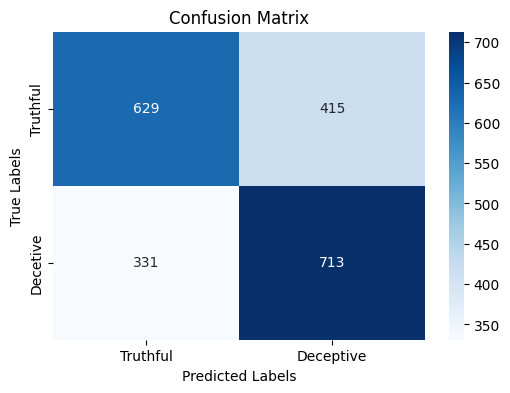


Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.60      0.63      1044
           1       0.63      0.68      0.66      1044

    accuracy                           0.64      2088
   macro avg       0.64      0.64      0.64      2088
weighted avg       0.64      0.64      0.64      2088

Accuracy Score: 0.64272030651341


In [ ]:
# Get performance metrics
get_performance_metrics(final_results)

Use this code to have more detailed performance metrics in terms of average and standard deviation across the cross-validation iterations (n= 5 in this case)
:

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

# Placeholder for storing scores for each split
scores_per_split = []
accuracy_per_split = []

# Unique splits
unique_splits = final_results['Split'].unique()

# Iterate through each split
for split in unique_splits:
    split_data = final_results[final_results['Split'] == split]

    # Compute classification report for the current split
    report = classification_report(
        split_data['labels'],
        split_data['Classifier_pred'],
        target_names=['Truthful', 'Deceptive'],
        output_dict=True
    )

    # Append metrics for this split
    scores_per_split.append({
        "Truthful_precision": report['Truthful']['precision'],
        "Truthful_recall": report['Truthful']['recall'],
        "Truthful_f1": report['Truthful']['f1-score'],
        "Deceptive_precision": report['Deceptive']['precision'],
        "Deceptive_recall": report['Deceptive']['recall'],
        "Deceptive_f1": report['Deceptive']['f1-score'],
        "macro_precision": report['macro avg']['precision'],
        "macro_recall": report['macro avg']['recall'],
        "macro_f1": report['macro avg']['f1-score'],
        "weighted_precision": report['weighted avg']['precision'],
        "weighted_recall": report['weighted avg']['recall'],
        "weighted_f1": report['weighted avg']['f1-score'],
        "accuracy": report['accuracy']
    })
    accuracy_per_split.append(report['accuracy'])

# Convert scores to a DataFrame for easier averaging
scores_df = pd.DataFrame(scores_per_split)

# Compute average and standard deviation for each metric
average_scores = scores_df.mean()
std_scores = scores_df.std()

# Format output as a summary table
summary_table = pd.DataFrame({
    "Metric": average_scores.index,
    "Average": average_scores.values,
    "Standard Deviation": std_scores.values
})

# Display average classification report with standard deviation
print("\nAverage Classification Report with Standard Deviation:")
print("Label           Precision       Recall          F1-score")
print("=" * 60)
for label in ["Truthful", "Deceptive", "macro", "weighted"]:
    precision_avg = average_scores[f"{label}_precision"]
    precision_std = std_scores[f"{label}_precision"]
    recall_avg = average_scores[f"{label}_recall"]
    recall_std = std_scores[f"{label}_recall"]
    f1_avg = average_scores[f"{label}_f1"]
    f1_std = std_scores[f"{label}_f1"]
    print(
        f"{label:<15} {precision_avg:.3f} (±{precision_std:.3f})  "
        f"{recall_avg:.3f} (±{recall_std:.3f})  "
        f"{f1_avg:.3f} (±{f1_std:.3f})"
    )

# Print overall averaged metrics
accuracy_avg = np.mean(accuracy_per_split)
accuracy_std = np.std(accuracy_per_split)
print(f"Averaged accuracy: {accuracy_avg:.3f} (±{accuracy_std:.3f})")


Average Classification Report with Standard Deviation:
Label           Precision       Recall          F1-score
Truthful        0.662 (±0.055)  0.602 (±0.144)  0.621 (±0.082)
Deceptive       0.639 (±0.055)  0.683 (±0.125)  0.653 (±0.056)
macro           0.651 (±0.042)  0.643 (±0.045)  0.637 (±0.049)
weighted        0.651 (±0.042)  0.643 (±0.045)  0.637 (±0.049)
Averaged accuracy: 0.643 (±0.040)


In [ ]:
final_results.to_csv('/content/llama_final_results.csv', index=False)
final_results.to_excel('/content/llama_final_results.xlsx', index=False)